# **Capitulo 5 – Time Series**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

Y vamos a crear la carpeta `images/time_series` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este cuaderno para guardar las figuras:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "time_series"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# ¿Qué es la dependencia serial? #

En los NoteBooks anteriores, investigamos las propiedades de las series temporales que se modelaban más fácilmente como propiedades *dependientes del tiempo*, es decir, con características que podíamos derivar directamente del índice temporal. Sin embargo, algunas propiedades de las series temporales sólo pueden modelarse como propiedades *dependientes seriales*, es decir, utilizando como características valores pasados de la serie objetivo. La estructura de estas series temporales puede no ser evidente a partir de un gráfico temporal; sin embargo, si se comparan con valores pasados, la estructura queda clara, como vemos en la figura siguiente.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/X0sSnwp.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Estas dos series tienen dependencia serial, pero no temporal. Los puntos de la derecha tienen coordenadas <code>(valor en el tiempo t-1, valor en el tiempo t)</code>.
</center></figcaption>
</figure>

Con la tendencia y la estacionalidad, entrenamos modelos para ajustar curvas a gráficos como los de la izquierda en la figura anterior -- los modelos estaban aprendiendo la dependencia temporal. El objetivo en este NoteBooks es entrenar modelos para ajustar curvas a gráficos como los de la derecha -- queremos que aprendan la dependencia serial.

### Ciclos

Una forma especialmente común de manifestarse la dependencia serial es en **ciclos**. Los ciclos son patrones de crecimiento y decadencia en una serie temporal asociada a cómo el valor en una serie en un momento dado depende de los valores en momentos anteriores, pero no necesariamente en el propio paso de tiempo.  El comportamiento cíclico es característico de los sistemas que pueden afectarse a sí mismos o cuyas reacciones persisten en el tiempo. Las economías, las epidemias, las poblaciones animales, las erupciones volcánicas y otros fenómenos naturales similares suelen mostrar un comportamiento cíclico.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/CC3TkAf.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Cuatro series temporales con comportamiento cíclico.
</center></figcaption>
</figure>

Lo que distingue el comportamiento cíclico de la estacionalidad es que los ciclos no dependen necesariamente del tiempo, como las estaciones. Lo que ocurre en un ciclo tiene menos que ver con la fecha concreta en que se produce y más con lo que ha ocurrido en el pasado reciente. La independencia (al menos relativa) del tiempo significa que el comportamiento cíclico puede ser mucho más irregular que la estacionalidad.

# Series lgs y gráficos de lags

Para investigar una posible dependencia serial (como los ciclos) en una serie temporal, necesitamos crear copias "lags" de la serie. **Retrasar** una serie temporal significa desplazar sus valores hacia delante uno o más pasos de tiempo, o equivalentemente, desplazar los tiempos en su índice hacia atrás uno o más pasos. En ambos casos, el efecto es que las observaciones de la serie retardada parecerán haber ocurrido más tarde en el tiempo.

Aquí se muestra la tasa de desempleo mensual en EE.UU. (`y`) junto con su primera y segunda series retardadas (`y_lag_1` y `y_lag_2`, respectivamente). Observe cómo los valores de las series retardadas se desplazan hacia delante en el tiempo.

In [3]:
import pandas as pd

reserve = pd.read_csv(
    "data/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

c:\Users\jamr1\miniconda3\envs\gym2\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
C:\Users\jamr1\AppData\Local\Temp\ipykernel_21472\1425649455.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\jamr1\AppData\Local\Temp\ipykernel_21472\1425649455.py:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime af

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


Retrasando una serie temporal, podemos hacer que sus valores pasados parezcan contemporáneos con los valores que intentamos predecir (en la misma fila, en otras palabras). Esto hace que las series retardadas sean útiles para modelizar la dependencia serial. Para predecir la serie de la tasa de desempleo de EE.UU., podríamos utilizar `y_lag_1` y `y_lag_2` como características para predecir el objetivo `y`. De este modo, se predeciría la tasa de desempleo futura en función de la tasa de desempleo de los dos meses anteriores.

### Gráficos Lag

Un **Lags Plot** de una serie temporal muestra sus valores en función de sus retardos. La dependencia serial de una serie temporal suele hacerse evidente al observar un gráfico de retardos. Podemos ver en este gráfico de retardo del *desempleo en EE.UU.* que existe una relación fuerte y aparentemente lineal entre la tasa de desempleo actual y las tasas pasadas.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Hvrboya.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Gráfico de retraso del desempleo en EE.UU. con las autocorrelaciones indicadas.
</center></figcaption>
</figure>

La medida de dependencia serial más utilizada se conoce como **autocorrelación**, que no es más que la correlación que tiene una serie temporal con uno de sus retardos. El *desempleo en EE.UU.* tiene una autocorrelación de 0,99 en el retardo 1, 0,98 en el retardo 2, y así sucesivamente.

### Elección de los retardos

Al elegir los retardos que se utilizarán como características, generalmente no será útil incluir *todos* los retardos con una gran autocorrelación. En *US Unemployment*, por ejemplo, la autocorrelación en el retardo 2 podría resultar enteramente de la información "descompuesta" del retardo 1 - sólo la correlación que se arrastra desde el paso anterior. Si el retardo 2 no contiene nada nuevo, no habría razón para incluirlo si ya tenemos el retardo 1.

La **autocorrelación parcial** indica la correlación de un retardo teniendo en cuenta todos los retardo anteriores, es decir, la cantidad de correlación "nueva" que aporta el retardo, por así decirlo. Trazar la autocorrelación parcial puede ayudarle a elegir qué características de retardo utilizar. En la figura siguiente, los rezagos 1 a 6 caen fuera de los intervalos de "no correlación" (en azul), por lo que podríamos elegir los rezagos 1 a 6 como características para el *desempleo estadounidense*. (El retardo 11 es probablemente un falso positivo).

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/6nTe94E.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Autocorrelaciones parciales del desempleo estadounidense hasta el lag 12 con intervalos de confianza del 95% de no correlación.
</center></figcaption>
</figure>

Un gráfico como el anterior se conoce como *correlograma*. El correlograma es para las características de retardo esencialmente lo que el periodograma es para las características de Fourier.

Por último, debemos tener en cuenta que la autocorrelación y la autocorrelación parcial son medidas de dependencia *lineal*. Dado que las series temporales del mundo real a menudo tienen dependencias no lineales sustanciales, es mejor mirar un gráfico de retardo (o utilizar alguna medida más general de dependencia, como [información mutua](https://www.kaggle.com/ryanholbrook/mutual-information)) al elegir características de retardo. La serie *Sunspots* tiene rezagos con dependencia no lineal que podríamos pasar por alto con la autocorrelación.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Q38UVOu.png" width=350, alt="">
    <figcaption style="textalign: center; font-style: italic"><center>Gráfico de retraso de la serie <em>Sunspots</em>.
</center></figcaption>
</figure>

Las relaciones no lineales como éstas pueden transformarse en lineales o bien aprenderse mediante un algoritmo adecuado.

# Ejemplo - Tendencias de la gripe

El conjunto de datos *Flu Trends* contiene registros de visitas al médico por gripe durante semanas entre 2009 y 2016. Nuestro objetivo es predecir el número de casos de gripe para las próximas semanas.

Adoptaremos dos enfoques. En el primero pronosticaremos las visitas al médico utilizando características de retardo. Nuestro segundo enfoque consistirá en pronosticar las visitas al médico utilizando retardos de *otro* conjunto de series temporales: los términos de búsqueda relacionados con la gripe recogidos en Google Trends.

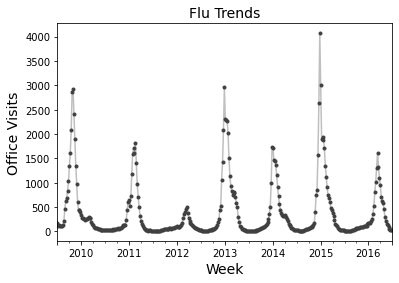

In [5]:

from pathlib import Path
from warnings import simplefilter

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.offsetbox import AnchoredText

simplefilter("ignore")


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


data_dir = Path("data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

Nuestros datos *Flu Trends* muestran ciclos irregulares en lugar de una estacionalidad regular: el pico tiende a producirse en torno al año nuevo, pero a veces antes o después, a veces mayor o menor. Modelizar estos ciclos con características de desfase permitirá a nuestro modelo reaccionar dinámicamente a las condiciones cambiantes en lugar de estar limitado a fechas y horas exactas como ocurre con las características estacionales.

Veamos primero los gráficos de desfase y autocorrelación:

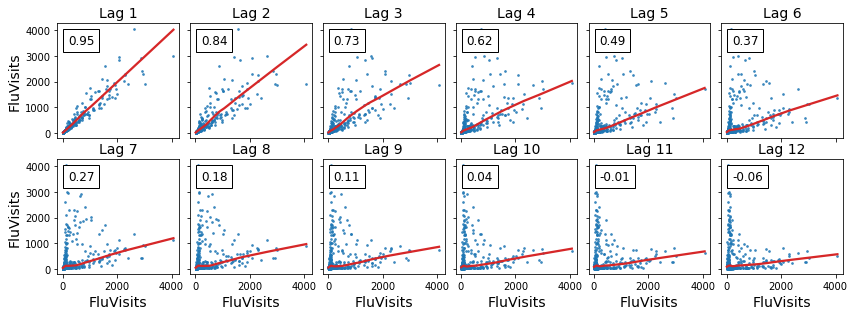

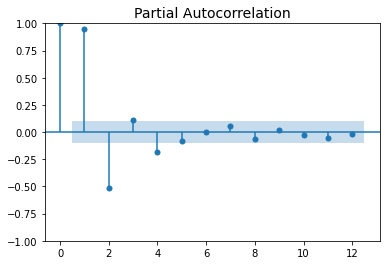

In [6]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

Los gráficos de lag indican que la relación de `FluVisits` con sus lags es mayoritariamente lineal, mientras que las autocorrelaciones parciales sugieren que la dependencia puede capturarse usando los lags 1, 2, 3 y 4. Podemos rezagar una serie temporal en Pandas con el método `shift`. Para este problema, rellenaremos los valores que faltan con `0.0`.

In [7]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

En NoteBooks anteriores, podíamos crear previsiones para tantos pasos como quisiéramos más allá de los datos de entrenamiento. Sin embargo, al utilizar funciones de desfase, estamos limitados a prever los pasos temporales cuyos valores de desfase están disponibles. Si utilizamos una función de desfase 1 el lunes, no podemos hacer una previsión para el miércoles porque el valor de desfase 1 necesario es el martes, que aún no ha ocurrido.

Veremos estrategias para resolver este problema mas adelante. Para este ejemplo, utilizaremos valores de un conjunto de prueba.

In [8]:
# Crear series objetivo y divisiones de datos
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit y predict
model = LinearRegression()  # `fit_intercept=True` ya que no utilizamos DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

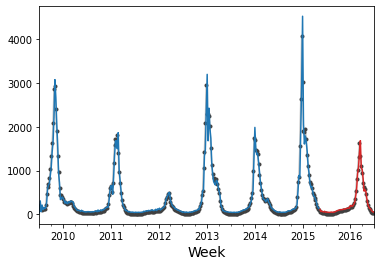

In [9]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

---

Si nos fijamos sólo en los valores de previsión, vemos que nuestro modelo necesita un paso de tiempo para reaccionar a los cambios bruscos de la serie objetivo. Se trata de una limitación habitual de los modelos que sólo utilizan lags de la serie objetivo como características.

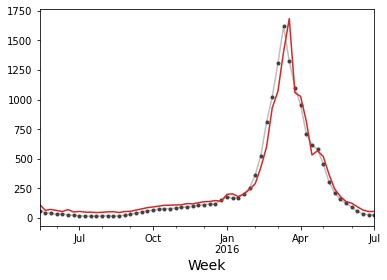

In [10]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Para mejorar la previsión podríamos intentar encontrar *indicadores líderes*, series temporales que pudieran proporcionar una "alerta temprana" de los cambios en los casos de gripe. Para nuestro segundo enfoque, añadiremos a nuestros datos de entrenamiento la popularidad de algunos términos de búsqueda relacionados con la gripe según Google Trends.

Si comparamos la frase de búsqueda "FluCough" (tos con gripe) con el objetivo "FluVisits" (visitas con gripe), veremos que estos términos de búsqueda podrían ser útiles como indicadores adelantados: las búsquedas relacionadas con la gripe tienden a ser más populares en las semanas previas a las visitas al consultorio.

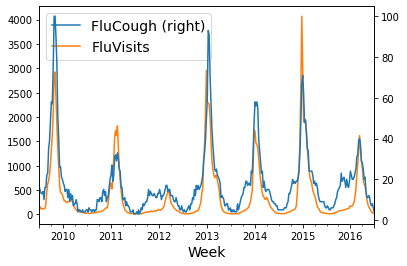

In [11]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

El conjunto de datos contiene 129 términos de este tipo, pero sólo utilizaremos algunos.

In [12]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Crear tres retardos para cada término de búsqueda
X0 = make_lags(flu_trends[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Crear cuatro retardos para el objetivo, como antes
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combinar para crear los datos de entrenamiento
X = pd.concat([X0, X1], axis=1).fillna(0.0)

Nuestras previsiones son un poco más aproximadas, pero nuestro modelo parece ser más capaz de anticipar aumentos repentinos de las visitas por gripe, lo que sugiere que las diversas series temporales de popularidad de las búsquedas fueron realmente eficaces como indicadores adelantados.

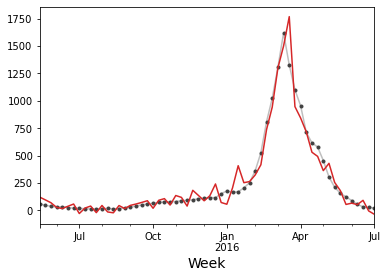

In [13]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

---

Las series temporales ilustradas en este NoteBook son lo que podríamos llamar "puramente cíclicas": no tienen tendencia ni estacionalidad evidentes. Sin embargo, no es raro que las series temporales posean tendencia, estacionalidad y ciclos, es decir, los tres componentes a la vez. Para modelizar estas series mediante regresión lineal, basta con añadir las características adecuadas para cada componente. Incluso puede combinar modelos entrenados para aprender los componentes por separado, lo que aprenderemos a hacer en la siguiente lección con *previsión híbrida*.